# Numeric solution of  models with polytropic EoS (mass density)

This notebook graphically shows the numeric solution, for different values of the polytropic index $n$, of relativistic anisotropic spheres with polytropic (II) EoS
\begin{equation}
    P = \kappa \rho^{1+\frac{1}{n}}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Compact object modeling

## Structure equations

The structure equations are the result of manipulating the Einstein field equations for a given metric and energy tensor. They are the equations to be solved to model compact objects. In the case of static conigurations, with spherical symmetry and anisotropic pressure, the structure equations consist of
\begin{eqnarray}
P^{\prime} &=& - \left(\rho + P \right) \frac{m + 4 \pi r^{3} P}{r(r - 2m)} + \frac{2}{r} \left(P_{\perp} - P \right)  \label{EqHid} \tag{1} \\
m^{\prime} &=& 4 \pi r^{2} \rho \label{MasDif} \tag{2}
\end{eqnarray}
where $\rho$ is energy density, $m$ is mass, $P$ is radial pressure and $P_{\perp}$ is tangential pressure. The prime denotes derivative with respect to $r$.

## Equation of State

An equation of state (EoS) is a mathematical model between state variables that describes the most important physical processes that occur in a thermodynamic system. The polytropic (II) EoS consists of a relationship such that
\begin{equation}
P = \kappa \rho^{1+\frac{1}{n}}\,. \label{PoliII} \tag{3}
\end{equation}

On the other hand, the anisotropic pressure is supposed to be of the form
\begin{equation}
\Delta\equiv P_{\perp} - P = C r (\rho + P) \frac{m + 4 \pi r^3 P}{r(r-2m)} \,, \label{Anisotropia} \tag{4}
\end{equation}
such that equation $\eqref{EqHid}$ is as
\begin{equation}
\frac{\mathrm{d}P}{\mathrm{d}r} = - h \frac{(\rho + P)(m + 4 \pi  r^3 P)}{r(r-2m)} \,, \label{EqHidCos} \tag{5}
\end{equation}
where $h = 1 - 2C$, and $C$ quantifies the anisotropy in the model.

## Lane-Emden equation

The structure equations can be written dimensionless when they are endowed with polytropic EoS. The result is known as the Lane-Emden equation, given by the change of variables
\begin{equation}
\psi^{n} \left(\xi \right) = \frac{\rho}{\rho_{c}} \ , \ \ \eta \left(\xi \right) = \frac{m}{4 \pi \rho_c a^{3}} \quad \textrm{and} \quad r = a\xi \,,
\end{equation}
where
\begin{equation}
a^{2} = \frac{\sigma \left(n + 1 \right)}{4 \pi \rho_c} \quad \textrm{and} \quad \sigma = \frac{P_{c}}{\rho_{c}}  \,.
\end{equation}
The subscript $c$ indicates that the variable is evaluated at the center of the configuration.

In this way, the dimensionless EoS $\eqref{PoliII}$ and $\eqref{Anisotropia}$ are
\begin{eqnarray}
P &=& \kappa \rho_{c}^{1 + \frac{1}{n}} \psi^{n+1} =  P_c \psi^{n+1} \quad \textrm{y} \label{PAdi} \tag{6} \\
\Delta &=& \frac{C (n+1) \left(\eta + \sigma \xi^{3} \psi^{n+1} \right)}{\xi - 2 \sigma (n+1)  \eta} (\psi^{n} + \sigma \psi^{n+1}) P_{c} \,, \label{AniAdi} \tag{7}
\end{eqnarray}
respectively. From which it is clear that $\sigma = \kappa \rho_{c}^{1/n}$.

Finally, equations $\eqref{EqHidCos}$ and $\eqref{MasDif}$, written in dimensionless form, are
\begin{eqnarray}
\dot{\psi} &=& - \frac{h(\eta + \sigma \xi^{3} \psi^{n+1})(1 + \sigma \psi)}{\xi \left\{\xi - 2 \sigma (n+1) \eta \right\}} \label{PsiPunto} \tag{8} \qquad \textrm{y} \\
\dot{\eta} &=& \xi^{2}\psi^{n} \label{EtaPunto} \tag{9} \,,
\end{eqnarray}
where dot indicates derivative with respect to $\xi$.

Therefore, the system of equations to integrate numerically is given by $\eqref{PsiPunto}$ and $\eqref{EtaPunto}$, with initial conditions
\begin{equation}
\psi (\xi = 0) = \psi_{c} = 1 \,, \quad \eta (\xi = 0) = \eta_{c} = 0  \,,
\end{equation}
and boundary condition
\begin{equation}
\psi(\xi = \xi_{b}) = 0 \,.
\end{equation}

In [3]:
# Defining system of equations: derivative of Psi and derivative of Eta as a function of xi
def funciones(xi,y, sigma, n, h):
    psi_, eta_ = y
    dydxi = [-h*(eta_ + sigma*xi**(3)*psi_**(n+1))*(1 + sigma*psi_)/xi/(xi - 2*(n+1)*sigma*eta_)
             ,xi**(2)*psi_**(n)]
    return dydxi

In [4]:
# The input parameters that characterize each model are defined: n, C, sigma

Lista_n = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]        # List of polytropic indices n 
print('Values for n: ',end='')                                                    
print(*Lista_n, sep=', ')

C = 1/8 # Anisotropic factor C

h = 1 - 2*C  

sigma = 0.25 # Ratio between central pressure and central density

Values for n: 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0


In [5]:
ListaModelos = [] # Container of the solutions for each polytropic index n

for i in range(len(Lista_n)):
    
    n = Lista_n[i]
    
    # Initial conditions
    Psi0 = 1.0
    Eta0 = 0.0
    y0 = [Psi0,Eta0]
    
    # Integration interval
    xi0 = 10**(-15) # Start
    ximax = 10000   # End, in case the condition to stop integration is not fulfilled
    xi_span = (xi0,ximax) # Integration space
    
    # Condition to stop integration (Dimensionless pressure less than 10**(-15))
    def stop_condition(xi,y,sigma,n,h):
        return y[0] - 10**(-15)
    stop_condition.terminal = True
    
    # Solution of the system of equations using the routine "solve_ivp" by means of the RK45 method
    # solve_ivp(Equations to integrate, Integration space, Initial conditions, Integration method,
    #           Condition to stop integration)
    soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                           args=(sigma,n,h),max_step=1/50)
    
    if soluciones.status != 0:
        xi = soluciones.t
        Psi = soluciones.y[0]
        Eta = soluciones.y[1]
    else:
        print('Model without boundary. Parameters: ', f'C = {C}, n = {n}, \u03c3 = {sigma}')
        continue
        
    # Xi normalized
    xiNorm = xi/xi[-1]
        
    # Energy density
    Densidad = Psi**(n)
    
    # Pressure divided by central pressure
    PNorm = Psi**(n+1)
    
    # Tangential divided by over central pressure
    PTNorm = (C*(n+1)*(Eta + sigma*Psi**(n+1)*xi**(3))/(xi - 2*Eta*sigma*(n+1)))*(Psi**(n) + sigma*Psi**(n+1)) + Psi**(n+1)
    
    # Normalized dimensionless mass
    m = Eta/Eta[-1] 
    
    # Metric function e^-{2 lambda}   
    e2lambda = (1 - 2*sigma*Eta*(n+1)/xi)
    
    # Metric function e^{2 nu}
    e2nu = ((1 + sigma*Psi)**(-2*(n+1)/h))*(1 - 2*(n+1)*sigma*Eta[-1]/xi[-1])
    
    ListaModelos.append([xiNorm, Densidad, PNorm, PTNorm, m, e2lambda, e2nu])

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Model without boundary. Parameters:  C = 0.125, n = 3.5, σ = 0.25
Model without boundary. Parameters:  C = 0.125, n = 4.0, σ = 0.25


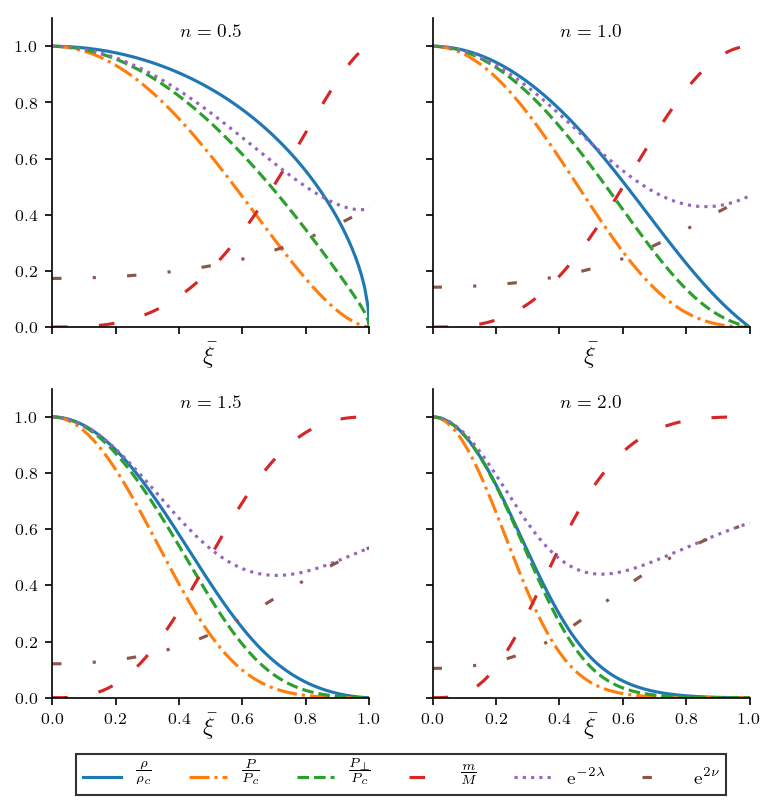

In [6]:
axes = ()

fig, axes = plt.subplots(nrows=2,ncols=2,sharey=True,sharex=True,figsize=(6,6),dpi=150)

Labels = [r'$\frac{\rho}{\rho_{c}}$',r'$\frac{P}{P_{c}}$',r'$\frac{P_{\perp}}{P_{c}}$',r'$\frac{m}{M}$',
        r'$\mathrm{e}^{- 2 \lambda}$',r'$\mathrm{e}^{2 \nu}$']

Line_Styles = ['-','-.','--',(0,(5,10)),':',(0,(3,10,1,10))]

ax = [axes[0][0],axes[0][1],axes[1][0],axes[1][1]]

for i in range(len(ax)):
    
    for j in range(1,len(ListaModelos[0])):
        
        ax[i].plot(ListaModelos[i][0],ListaModelos[i][j],'-',label=Labels[j-1],linestyle=Line_Styles[j-1])
        ax[i].set_xbound(0.0,1.0)
        ax[i].set_ybound(0.0,1.1)
        ax[i].set_xlabel(r'$\bar{\xi}$',fontsize=12)
        ax[i].xaxis.set_label_coords(0.5, -0.05)
        ax[i].set_title(r'$n = {}$'.format(Lista_n[i]),x=0.5,y=0.9,fontsize=9)
        ax[i].spines['right'].set_color('none')
        ax[i].spines['top'].set_color('none')
         
ax[3].legend(ncol=6,loc=(-1.125,-0.315),edgecolor='k',fancybox=False,fontsize=9)

plt.show()